<a href="https://colab.research.google.com/github/Gooogr/Book_Ian_Pointer_PyTorch_for_DL/blob/master/Ch2.Perceptron_image_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import cv2
import urllib.request

In [40]:
# Mount Google disk 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
! ln -s "/content/drive/My Drive" "/content/mydrive"

Mounted at /content/drive


In [2]:
! nvidia-smi

Tue May  4 11:57:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [41]:
BATCH_SIZE = 32
INPUT_SIZE = 64
EPOCHS = 10
PROJECT_FOLDER = '/content/mydrive/colab_notebooks/Book_PyTorch'

**Prepare dataset**

In [4]:
% mkdir --parents ./datasets/fish_and_cat
% cd ./datasets/fish_and_cat

/content/datasets/fish_and_cat


In [5]:
! wget --quiet https://raw.githubusercontent.com/falloutdurham/beginners-pytorch-deep-learning/master/chapter2/download.py
! wget --quiet https://raw.githubusercontent.com/falloutdurham/beginners-pytorch-deep-learning/master/chapter2/images.csv

In [6]:
%%capture
!python download.py
# Takes ~ 20 min in google collab

In [7]:
# Return to root of project
% cd ../../

/content


Setting up directories pathes

In [8]:
train_path = './datasets/fish_and_cat/train/'
val_path = './datasets/fish_and_cat/val/'
test_path = './datasets/fish_and_cat/test/'

Create datasets with ImageFolder

In [9]:
img_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #pre-compute constants
                         std=[0.229, 0.224, 0.225])
])

In [10]:
def check_image(path):
    '''
    Function will do a sanity check to make sure PIL can actually open the file.
    Passed to the is_valid_file parameter in the ImageFolder.
    '''
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [11]:
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=img_transforms, is_valid_file=check_image)
val_data = torchvision.datasets.ImageFolder(root=val_path, transform=img_transforms, is_valid_file=check_image)
test_data = torchvision.datasets.ImageFolder(root=test_path, transform=img_transforms, is_valid_file=check_image)

Create data loaders

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

**Create model**

In [13]:
class SimpleNet(nn.Module):
    
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE * INPUT_SIZE * 3, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 2)
        
    def forward(self, x):
        x = x.view(-1 , INPUT_SIZE * INPUT_SIZE * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #Final Softmax will be in the loss function - categorical crossentropy
        return x

In [14]:
simplenet = SimpleNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

**Send model to GPU**

In [15]:
print('Is cuda available? - ', torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
simplenet.to(device);

Is cuda available? -  True


**Training**

In [16]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=None, device='cuda'):
    '''
    device option copy on cpu/gpu only batch, not model. Model was sent to cpu/gpu in the cell below!
    '''
    for epoch in range(epochs):
        training_loss = 0
        val_loss = 0
        
        model.train() #set model to the train mode
        for batch in train_loader:
            optimizer.zero_grad() #set gradients to zero for every new bath
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward() # backward propagation
            optimizer.step() # update weights
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
            
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            val_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        val_loss /= len(val_loader.dataset)
        
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.\
              format(epoch, training_loss, val_loss, num_correct / num_examples)) 

In [17]:
%%time
train(simplenet, optimizer, nn.CrossEntropyLoss(), train_loader,val_loader, epochs=EPOCHS, device=device)

Epoch: 0, Training Loss: 4.45, Validation Loss: 2.70, accuracy = 0.47
Epoch: 1, Training Loss: 2.27, Validation Loss: 6.15, accuracy = 0.27
Epoch: 2, Training Loss: 3.13, Validation Loss: 2.17, accuracy = 0.50
Epoch: 3, Training Loss: 1.41, Validation Loss: 0.81, accuracy = 0.58
Epoch: 4, Training Loss: 0.66, Validation Loss: 0.66, accuracy = 0.71
Epoch: 5, Training Loss: 0.45, Validation Loss: 0.62, accuracy = 0.73
Epoch: 6, Training Loss: 0.38, Validation Loss: 0.61, accuracy = 0.72
Epoch: 7, Training Loss: 0.34, Validation Loss: 0.63, accuracy = 0.72
Epoch: 8, Training Loss: 0.31, Validation Loss: 0.63, accuracy = 0.74
Epoch: 9, Training Loss: 0.29, Validation Loss: 0.66, accuracy = 0.73
CPU times: user 38.5 s, sys: 472 ms, total: 38.9 s
Wall time: 39 s


**Making predictions**

In [18]:
def url_to_image(url, save_path=None):
    '''
    Download the image by url-link, convert it to a NumPy array. Encode it into OpenCV format.
    input:
        url - direct url link to image 
    output:
        OpenCV image.
    '''
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")

    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    if save_path is not None:
        cv2.imwrite(save_path, image)
    else:
        return image

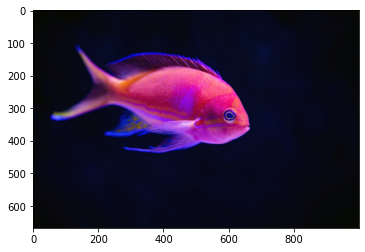

In [26]:
img_url = 'https://images.unsplash.com/photo-1524704654690-b56c05c78a00?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80'
img_matrix = url_to_image(img_url)[:,:,::-1]
plt.imshow(img_matrix);

In [38]:
labels = ['cat', 'fish']
raw_img = Image.fromarray(np.uint8(img_matrix)).convert('RGB') # numpy array -> PIL image
img = img_transforms(raw_img).to(device)

preds = F.softmax(simplenet(img), dim=1)
print(preds)
print(labels[preds.argmax().item()])


tensor([[0.3423, 0.6577]], device='cuda:0', grad_fn=<SoftmaxBackward>)
fish


**Saving models**

In [42]:
# Entire model
torch.save(simplenet, os.path.join(PROJECT_FOLDER,
                                   "./ch2/simplenet")) 
simplenet = torch.load(os.path.join(PROJECT_FOLDER,
                                    "./ch2/simplenet"))

In [43]:
# Weights only
torch.save(simplenet.state_dict(), os.path.join(PROJECT_FOLDER, 
                                                "./ch2/simplenet_weights"))    
simplenet = SimpleNet()
simplenet_state_dict = torch.load(os.path.join(PROJECT_FOLDER, 
                                               "./ch2/simplenet_weights"))
simplenet.load_state_dict(simplenet_state_dict)

<All keys matched successfully>